## Examining input-ouput relationship of invariant networks

## Imports

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

mpl_rc = "../assets/matplotlibrc"
plt.style.use(mpl_rc)

import numpy as np
import os
import pickle
import pandas as pd
import brian2 as b2
from torch import Tensor

from automind.sim import b2_interface, runners, b2_models, b2_inputs

from automind.inference import inferer
from automind.utils import data_utils, analysis_utils, dist_utils, plot_utils
from brian2 import *
import json

In [2]:
data_dirs = "../datasets/discovered_posterior_samples/synthetic/"
path_dict = data_utils.extract_data_files(
    data_dirs,
    [
        
        "posterior.pickle",
        "params_dict_analysis_updated.pickle",
        "summary_data_merged.csv",
    ],
)
df_xos, posterior, params_dict = data_utils.load_df_posteriors(path_dict)
_, _, _, _, cols_psd = data_utils.separate_feature_columns(df_xos)
print(posterior)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../datasets/discovered_posterior_samples/synthetic/'

In [3]:
f_bounds = posterior.x_bounds_and_transforms["freq_bounds"]
print(f"Density estimator was trained on PSD between {f_bounds} Hz.")

# Extract the frequency bounds and trim correspondingly
freqs = data_utils.decode_df_float_axis(cols_psd)
f_idx = (freqs >= f_bounds[0]) & (freqs <= f_bounds[1])
freqs, cols_features = freqs[f_idx], np.array(cols_psd)[f_idx]

NameError: name 'posterior' is not defined

In [4]:
idx_xo = 10030 #Replace with any from the list of observation indices
df_xos_preproc, _, _, _ = dist_utils.preproc_dataframe_psd(
    df_xos.loc[[idx_xo]],
    posterior.x_bounds_and_transforms,
    drop_nans=False,
    replace_infs=True,
)
xo = df_xos_preproc.loc[idx_xo][cols_features].values
xo_tensor = posterior.x_standardizing_func(Tensor(xo[None, :]))
print(f"Target observation has shape {xo_tensor.shape}")

0 sims dropped due to early stopping.
0 sims dropped due to manual criteria.
0 sims dropped due to power threshold discard.
0 samples discarded in total.
Target observation has shape torch.Size([1, 990])


### Selecting existing network parameters 

In [4]:
observation_indices = df_xos[df_xos['inference.type']=='gt_resim'].index.tolist()

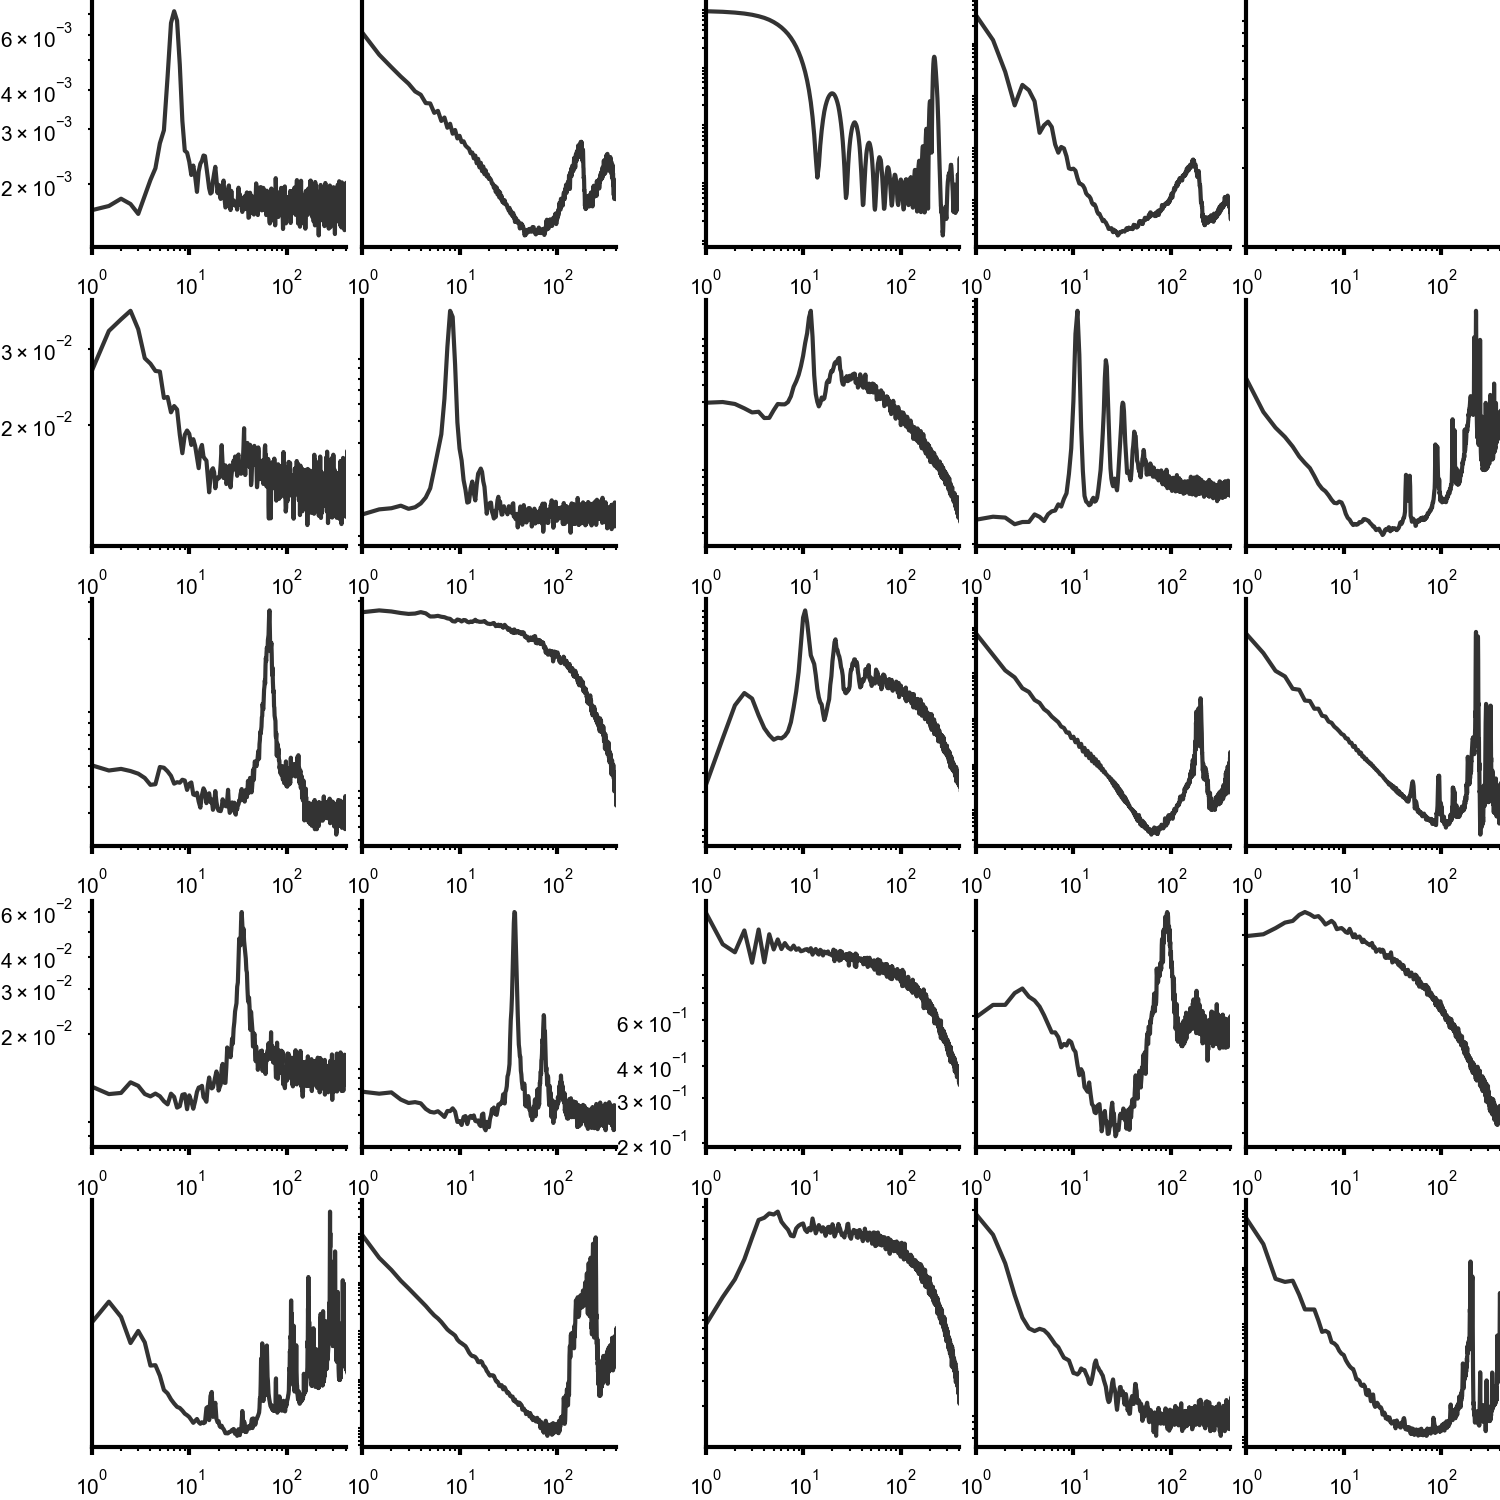

In [5]:
#LFP profile / observations 
fig, ax = plt.subplots(5,5, figsize=(5,5))
ax = ax.flatten()
for i in range(len(observation_indices)):
    xo_raw = df_xos.loc[observation_indices[i]][cols_features].values
    ax[i].loglog(freqs, xo_raw, "k", alpha=0.8)
    ax[i].set_yticks([])
    ax[i].set_xlim([1, 400])


In [ ]:
id = 10030 #Select from observations 
n_samples = 3 #How many networks you want to simulate
xo = df_xos.iloc[id][cols_features].values 
samples = df_xos.iloc[id:][cols_features].values
log_samples = True
stdz_func = posterior.x_standardizing_func
standardised_samples = dist_utils.log_n_stdz(samples,stdz_func)
include_mapnmean = True
sort_samples=True
sort_weights=((freqs>=50) & (freqs<=400)) #Filter unwanted frequencies 

samples_sorted, dists, idx_sorted = dist_utils.sort_closest_to_xo(
                    standardised_samples[0,:], standardised_samples, "mse",top_n=None, weights=sort_weights
                )

params_dict['params_settings']['sim_time'] = 30.1 * b2.second #Changing simulation time to 30 seconds 
df_samples = df_xos.iloc[id+idx_sorted[0:n_samples+1]] #Top x samples closest to the "true" oscillation
df_samples = df_samples.iloc[:,3:33] #Only network information (or else unwanted info will be passed to fill_params_dict)


WARNING    c:\users\brian.laptop-8bs4kr2p\automind\automind\utils\dist_utils.py:428: RuntimeWarning: divide by zero encountered in log10
  samples = np.log10(samples)
 [py.warnings]
WARNING    c:\users\brian.laptop-8bs4kr2p\automind\automind\utils\dist_utils.py:463: RuntimeWarning: invalid value encountered in multiply
  dist = (dists * weights).mean(1)
 [py.warnings]


WARNING    C:\Users\brian.LAPTOP-8BS4KR2P\AppData\Local\Temp\ipykernel_21232\1886566056.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
 [py.warnings]


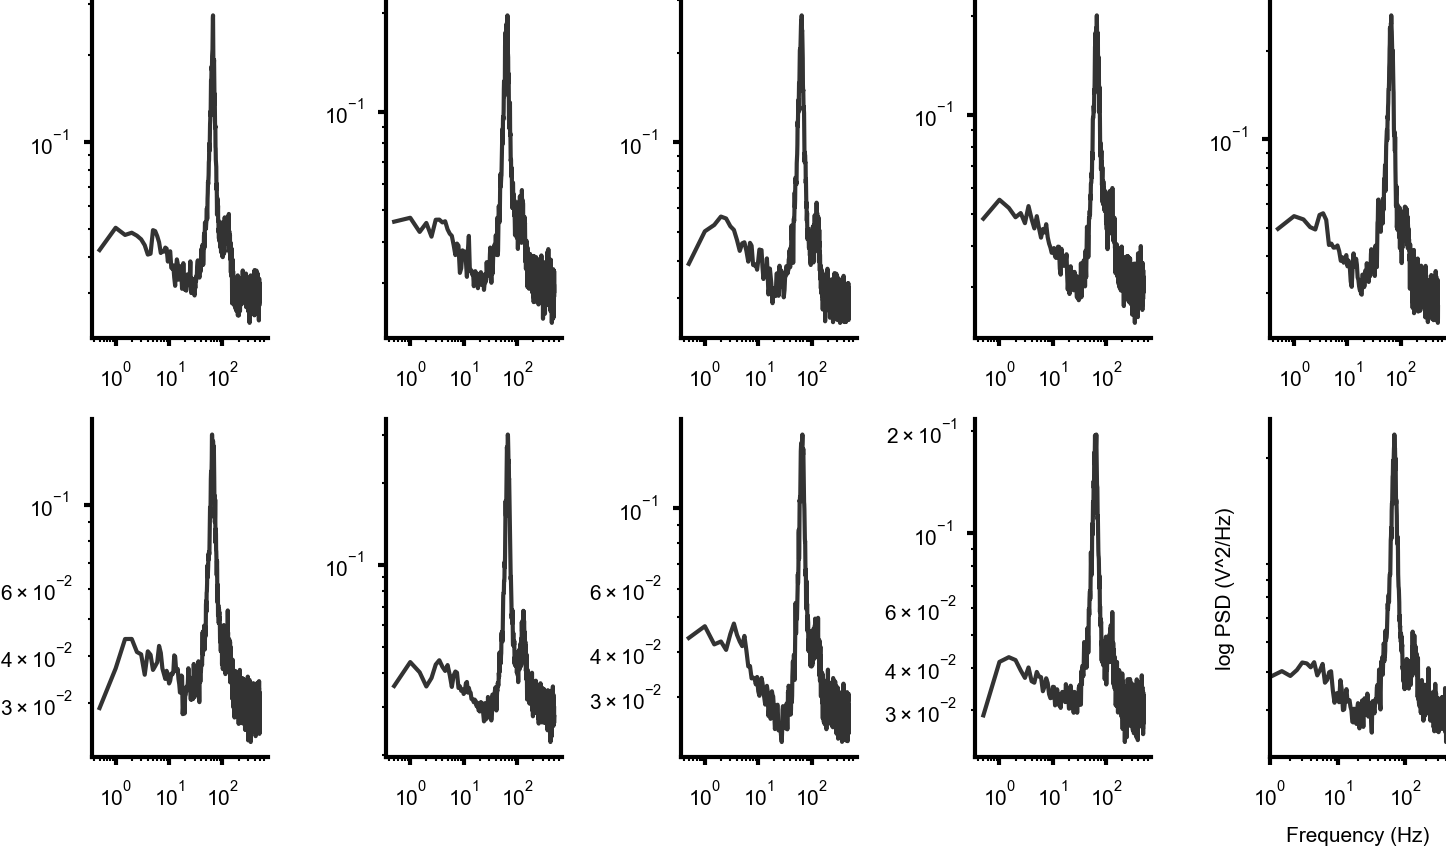

In [7]:
#LFP profiles of the selected networks 
fig, ax = plt.subplots(2,5,figsize=(5,3))
ax = ax.flatten()
for i in range(len(ax)):
    idx_xo = 10030 + idx_sorted[i]
    xo_raw = df_xos.loc[idx_xo][cols_features].values
    ax[i].loglog(freqs, xo_raw, "k", alpha=0.8)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("log PSD (V^2/Hz)")
    plt.yticks([])
    plt.xlim([1, 400])
    plt.tight_layout()

In [11]:
# NOTE: This sets the correct early-stopping condition, i.e., to assess the simulation from 0.1 to 10.1 seconds.
params_dict['params_analysis']['analysis_window'] = [0.1, None] 
params_dict_run = data_utils.fill_params_dict(
    params_dict, df_samples, posterior.as_dict, n_samples
)

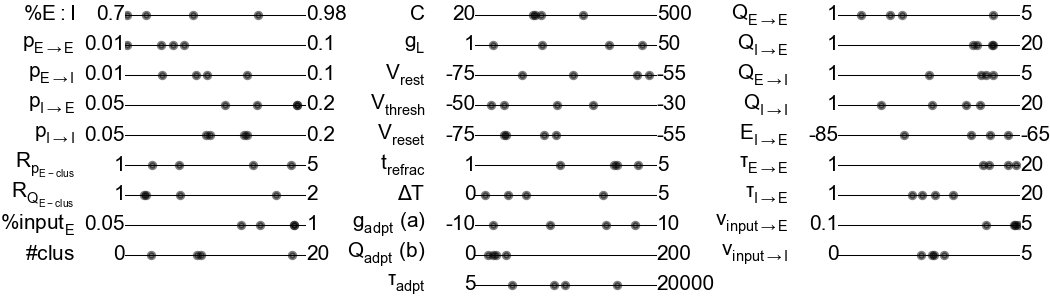

In [8]:
from automind.sim.default_configs import MKI_pretty_param_names

_, theta_minmax = dist_utils.standardize_theta(posterior.prior.sample((1,)), posterior)
fig, axs = plt.subplots(10, 3, figsize=(3.5, 1))
plot_utils.plot_params_1D(
    df_samples[posterior.names].values,
    theta_minmax,
    MKI_pretty_param_names,
    (fig, axs),
    color="k",
    draw_canvas=True,
    draw_kde=False,
    draw_samples=True,
    labelpad=12,
    draw_median=False,
    sample_ms=3,
    sample_alpha=0.5,
);

### Simulation

In [4]:
#wrapper 
def adex_simulator(params_dict):
    """
    Simulator wrapper for AdEx net, run simulations and collect data.
    """

    print(
        f"{params_dict['params_settings']['batch_seed']}-{params_dict['params_settings']['random_seed']}",
        end="|",
    )

    try:
        # set up and run model with early stopping
        network_type = params_dict["params_settings"]["network_type"]
        if (not network_type) or (network_type == "adex"):
            net_collect = b2_models.adaptive_exp_net(params_dict)
        elif network_type == "adex_clustered": #Change function params here to switch between different modes, inputs etc
            net_collect = b2_models.adaptive_exp_net_clustered_cog(params_dict, mode='cluster',stim_cluster=2,custom_cluster_input=[b2_inputs.DM_simple(params_dict,0.5*10**-9),b2_inputs.DM_simple(params_dict,0.7*10**-9)])
        
        # run the model
        params_dict, net_collect = runners.run_net_early_stop(net_collect, params_dict)

        # return pickleable outputs for pool
        spikes, timeseries = data_utils.collect_raw_data(net_collect, params_dict)

        return params_dict, spikes, timeseries

    except Exception as e:
        print("-----")
        print(e)
        print(
            f"{params_dict['params_settings']['batch_seed']}-{params_dict['params_settings']['random_seed']}: FAILED"
        )
        print("-----")
        return params_dict, {}, {}


In [126]:
from time import time

In [ ]:
#Simulation 
cache_path = "./.cache/"
b2_interface.clear_b2_cache(cache_path)
b2_interface.set_b2_cache(cache_path, True)


sim_parallel = False
if sim_parallel:
    from multiprocessing import Pool

    start_time = time()
    with Pool(n_samples) as pool:
        sim_collector = pool.map(adex_simulator, params_dict_run)
    print(f"Simulations took {time()-start_time:.2f} seconds.")
else:
    sim_collector = []
    for i_sim in range(n_samples):
        start_time = time()
        sim_collector.append(adex_simulator(params_dict_run[i_sim]))
        print(f"Simulation {i_sim+1}/{n_samples} took {time()-start_time:.2f} seconds.")


cache non-existent.
7149324-42|Simulation 1/3 took 33.60 seconds.
7149324-42|Simulation 2/3 took 34.29 seconds.
7149324-42|Simulation 3/3 took 34.39 seconds.
cache non-existent.


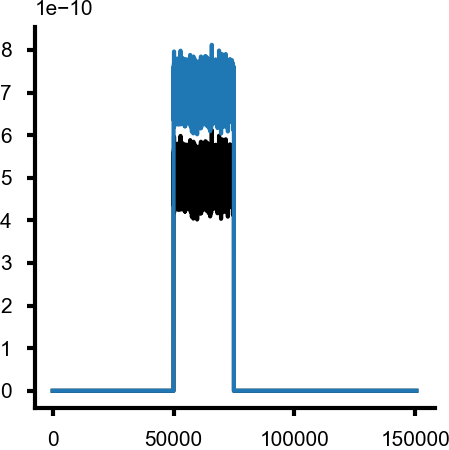

In [128]:
plt.plot(sim_collector[0][0]['params_net']['input'][0])
plt.plot(sim_collector[0][0]['params_net']['input'][1])

In [129]:
results_collector = [
    analysis_utils.compute_summary_features(sims[1], sims[0]) for sims in sim_collector
]

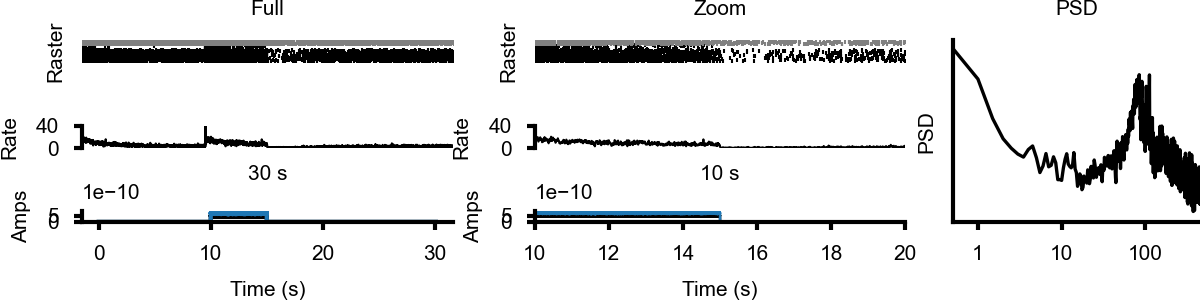

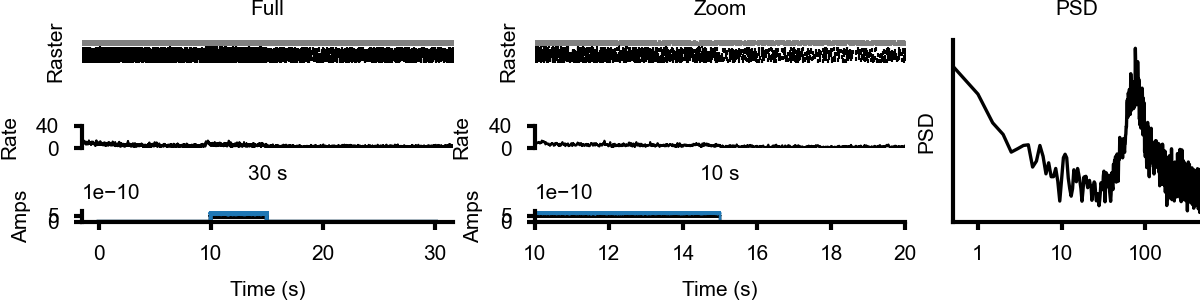

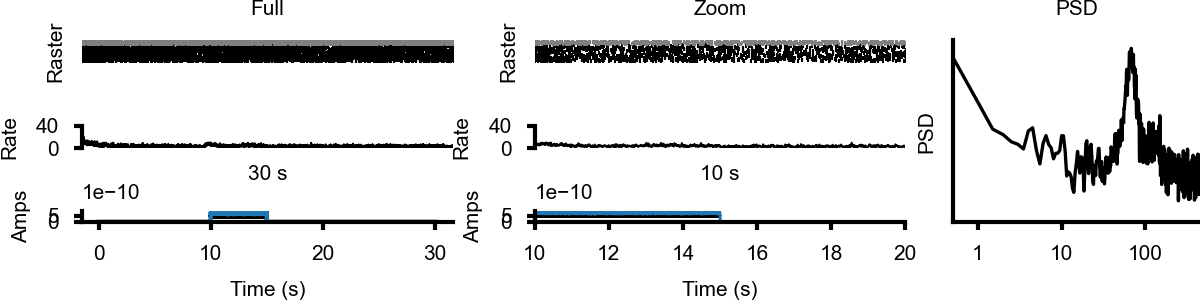

In [ ]:
#Added plots for inputs at the bottom 
from matplotlib import gridspec

xlims = [0, 30]
xlims_zoom = [10, 20]
every_other = 5

for i_sim, results in enumerate(results_collector):
    # left: full view, middle: zoomed view, right: PSD spanning all rows.
    fig = plt.figure(figsize=(4,1.5), constrained_layout=True)
    gs = gridspec.GridSpec(3, 3, figure=fig,
                           width_ratios=[3, 3, 2],
                           height_ratios=[2, 2, 1])
    
    #Left column - Full view
    ax_full_raster = fig.add_subplot(gs[0, 0])
    ax_full_rate   = fig.add_subplot(gs[1, 0])
    ax_full_input  = fig.add_subplot(gs[2, 0])
    
    #Middle column - Zoomed view 
    ax_zoom_raster = fig.add_subplot(gs[0, 1])
    ax_zoom_rate   = fig.add_subplot(gs[1, 1])
    ax_zoom_input  = fig.add_subplot(gs[2, 1])
    
    #Right column - PSD 
    ax_psd = fig.add_subplot(gs[:, 2])
    
    #Full view
    #Plot full raster
    plot_utils._plot_raster_pretty(
        sim_collector[i_sim][1], XL=xlims, every_other=every_other, fontsize=5, ax=ax_full_raster
    )
    ax_full_raster.set_title("Full")
    
    #Plot full rate
    plot_utils._plot_rates_pretty(
        results_collector[i_sim]["pop_rates"],
        XL=xlims,
        pops_to_plot=["avgpop_rate"],
        ylim_past=10 * 1000,
        fontsize=5,
        ax=ax_full_rate,
        color="k",
    )
    ax_full_rate.set_ylabel("Rate")
    ax_full_rate.set_ylim([0, 40])
    ax_full_rate.set_yticks([0, 40])
    
    #Plot full input signal
    params_net = sim_collector[0][0]['params_net']

    # Try to get the input from one key and fall back to the other
    inputs = params_net.get('input')
    if inputs is not None and not isinstance(inputs, list):
        inputs = [inputs]
    if inputs is not None:
        sim_time = sim_collector[0][0]['params_settings']['sim_time']
        dt = sim_collector[0][0]['params_settings']['dt']
        time_vector = np.linspace(0, sim_time, int(sim_time/dt))
        
        ax_full_input.set_xlabel("Time (s)")
        ax_full_input.set_ylabel("Amps")
        for inp in inputs:
            ax_full_input.plot(time_vector, inp)
    else:
        print("No input found in the simulation parameters.")
    
    #Zoomed view
    #Plot zoomed raster
    plot_utils._plot_raster_pretty(
        sim_collector[i_sim][1], XL=xlims_zoom, every_other=every_other, fontsize=5, ax=ax_zoom_raster
    )
    ax_zoom_raster.set_title("Zoom")
    #Plot zoomed rate
    plot_utils._plot_rates_pretty(
        results_collector[i_sim]["pop_rates"],
        XL=xlims_zoom,
        pops_to_plot=["avgpop_rate"],
        ylim_past=10 * 1000,
        fontsize=5,
        ax=ax_zoom_rate,
        color="k",
    )
    ax_zoom_rate.set_ylabel("Rate")
    ax_zoom_rate.set_ylim([0, 40])
    ax_zoom_rate.set_yticks([0, 40])
    
    #Plot zoomed input signal
    ax_zoom_input.set_xlabel("Time (s)")
    ax_zoom_input.set_ylabel("Amps")
    if inputs is not None:
        for inp in inputs:
            ax_zoom_input.plot(time_vector, inp, linewidth=0.6)
            ax_zoom_input.set_xlim(xlims_zoom)
    
    #PSD
    plot_utils._plot_psd_pretty(
        results_collector[i_sim]["summary_psd"], ["avgpop_rate"], ax=ax_psd, fontsize=5
    )
    ax_psd.set_title("PSD")
    plt.show()


## Multiple inputs 

In [6]:
#wrapper function for multiple inputs - 
def adex_simulator_multiple(params_dict,input):
    """
    Simulator wrapper for AdEx net, run simulations and collect data.
    """

    print(
        f"{params_dict['params_settings']['batch_seed']}-{params_dict['params_settings']['random_seed']}",
        end="|",
    )
    try:
        # set up and run model with early stopping
        network_type = params_dict["params_settings"]["network_type"]
        if (not network_type) or (network_type == "adex"):
            net_collect = b2_models.adaptive_exp_net(params_dict)
        elif network_type == "adex_clustered": #Change function params here to switch between different modes, inputs etc
            net_collect = b2_models.adaptive_exp_net_clustered_cog(params_dict, mode = 'single', custom_input = input)
        
        # run the model
        params_dict, net_collect = runners.run_net_early_stop(net_collect, params_dict)

        # return pickleable outputs for pool
        spikes, timeseries = data_utils.collect_raw_data(net_collect, params_dict)

        return params_dict, spikes, timeseries

    except Exception as e:
        print("-----")
        print(e)
        print(
            f"{params_dict['params_settings']['batch_seed']}-{params_dict['params_settings']['random_seed']}: FAILED"
        )
        print("-----")
        return params_dict, {}, {}


In [ ]:
#Simulation 
cache_path = "./.cache/"
b2_interface.clear_b2_cache(cache_path)
b2_interface.set_b2_cache(cache_path, True)

inputs = np.arange(0,2.5*10^-9,10**-10) #Replace this with the list of inputs you want to test on
for input in inputs: 
    sim_parallel = False
    if sim_parallel:
        from multiprocessing import Pool

        start_time = time()
        with Pool(n_samples) as pool:
            sim_collector = pool.map(adex_simulator, params_dict_run) #I haven't personally run this so I am not sure how to change it 
        print(f"Simulations took {time()-start_time:.2f} seconds.")
    else:
        sim_collector = []
        for i_sim in range(n_samples+1): #n_samples taken from the distribution plus gt_resim
            start_time = time()
            sim_collector.append(adex_simulator_multiple(params_dict_run[i_sim],input)) #It should work here 
            print(f"Simulation {i_sim+1}/{n_samples} took {time()-start_time:.2f} seconds.")

b2_interface.clear_b2_cache(cache_path)



In [ ]:
results_collector = [
    analysis_utils.compute_summary_features(sims[1], sims[0]) for sims in sim_collector
]

## Cluster analysis

In [131]:
n_sims = len(sim_collector)
membership = [sim_collector[i][0]['params_net'].get('membership', np.array([])) for i in range(n_sims)]
num_clusters = [int(sim_collector[i][0]['params_net']['n_clusters']) for i in range(n_sims)]

#2 sorted indices, one based on the first membership and the other on the second 
#sort_idx_special = [np.argsort(np.sum(membership[0],axis=1)) if membership[i].size > 0 else [] for i in range(n_sims)]
sorted_index_0 = [np.argsort(membership[i][:,0]) if membership[i].size > 0 else [] for i in range(n_sims)] #First membership
sorted_index_1 = [np.argsort(membership[i][:,1]) if membership[i].size > 0 else [] for i in range(n_sims)] #Second membership



In [136]:
#Sorting the spikes by clusters
all_sorted_spikes_by_cluster = []
for i in range(n_sims):
    spike_dict = sim_collector[i][1]
    sorted_spikes_by_cluster = {
        'exc_spikes': {}, 
        'inh_spikes': spike_dict.get('inh_spikes', {}) 
    }
    exc_spike_dict = spike_dict['exc_spikes'] #Spikes from each simulation 
    if membership[i].size > 0: #i.e. having clusters 
        for new_idx, old_idx in enumerate(sorted_index_0[i]): 
            if old_idx in exc_spike_dict: #Not all spikes are saved but membership saves all neurons 
                sorted_spikes_by_cluster['exc_spikes'][new_idx] = exc_spike_dict[old_idx]
    
        all_sorted_spikes_by_cluster.append(sorted_spikes_by_cluster)
    else: #If no clusters
        all_sorted_spikes_by_cluster.append({
            'exc_spikes': exc_spike_dict, 
            'inh_spikes': spike_dict.get('inh_spikes')
        })


WARNING    C:\Users\brian.LAPTOP-8BS4KR2P\AppData\Local\Temp\ipykernel_21232\30307010.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
 [py.warnings]


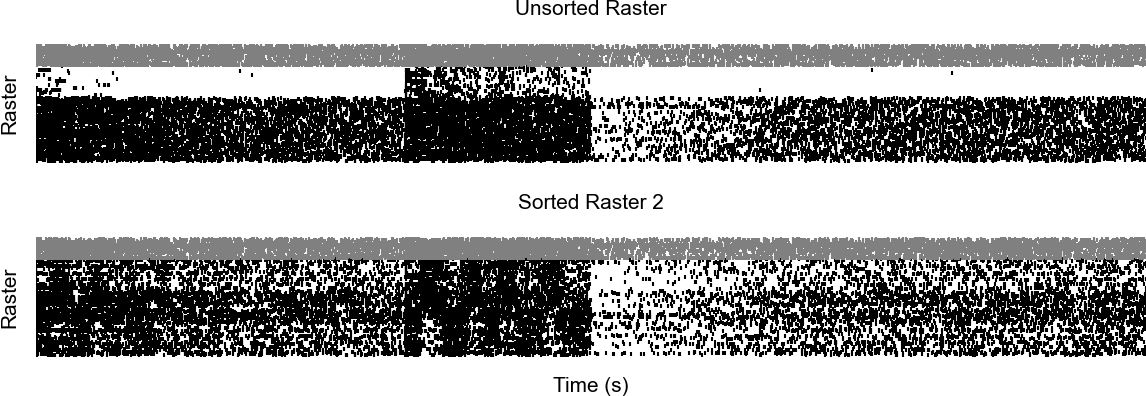

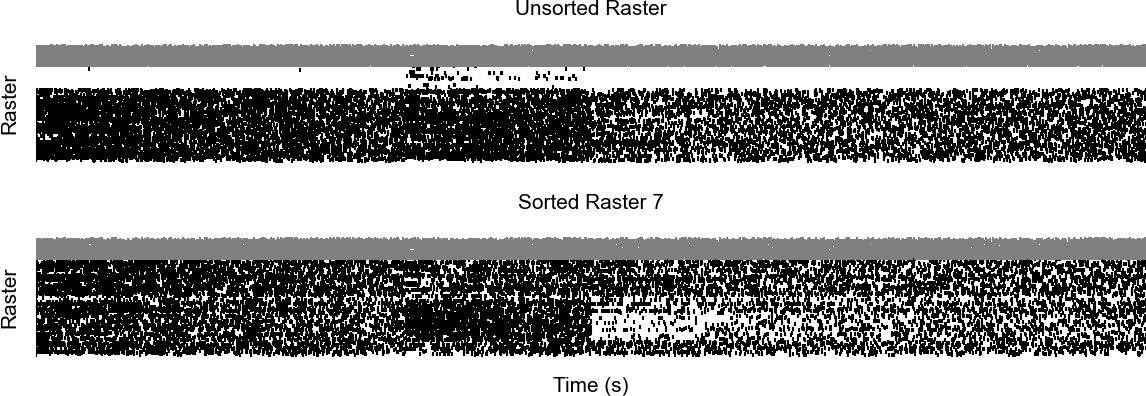

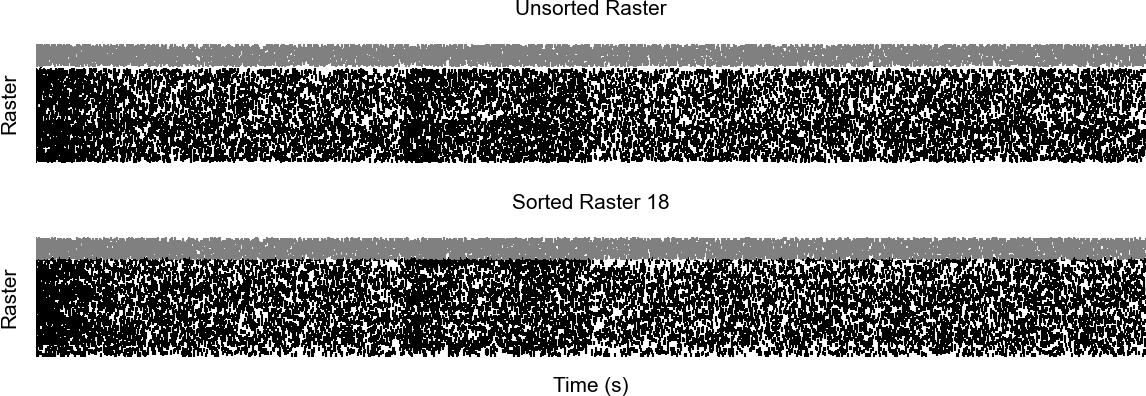

In [ ]:
#Comparison between plotting with and without clusters. Note some clusters could be underrepresented as we subsampled neurons.

#IMPORTANT: You can see from the top the neurons that only fire during the input disappear in the bottom plot. I will try to figure out why 
#first so please don't use this part yet, sorry!

xlims_full = [0, 30]
every_other = 1

for i_sim in range(n_sims):
    # left: full view, middle: zoomed view, right: PSD spanning all rows.
    fig, (ax_unsort, ax_sort) = plt.subplots(2, 1, figsize=(4,1.5), sharex=True)
    #Unsorted raster
    plot_utils._plot_raster_pretty(
        sim_collector[i_sim][1],
        XL=xlims_full,
        every_other=every_other,
        fontsize=5,
        ax=ax_unsort
    )
    ax_unsort.set_title("Unsorted Raster")

    #Sorted raster 
    plot_utils._plot_raster_pretty(
        all_sorted_spikes_by_cluster[i_sim], 
        XL=xlims, 
        every_other=every_other, 
        fontsize=5, 
        ax=ax_sort
    )

    ax_sort.set_title(f"Sorted Raster {num_clusters[i_sim]}")
    ax_sort.set_xlabel("Time (s)")

    # Adjust the layout to minimize white space
    plt.tight_layout()
    plt.show()
